### Image Classification with neural networks

### Approach
- [Import Libraries](#import-libraries)
- [Data Loading and Transformation](#data-loading-transformation)
- [Define Custom CNN Model](#2-define-custom-cnn-model)
- [Train the model](#3-train-the-model)
- [Evaluate the model](#4-evaluate-the-model)
- [Generate Confusion Matrix](#5-confusion-matrix)
- [Plot Test images with predictions](#6-test-images-with-predictions) 

<a id="import-libraries"></a>

In [45]:
#Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

<a id="data-loading-transformation"></a>

### 1. Data Loading and Transformation

In [34]:
data_dir = 'C:/Users/grees/OneDrive/Desktop/ML_CNN/STA380-master/STA380-master/data/EuroSAT_RGB'  # Path to image data

In [35]:
# define image processing pipeline to resize the images, convert to tensor format and normalize the image embeddings
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resizing to 128 * 128 
    transforms.ToTensor(),  # Convert to tensor. Tensor is a datatype needed for NN
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #RGB means and standard deviation which will be used to normalise data
])

In [36]:
# apply image processing pipeline to convert images into an analyzable format
dataset = datasets.ImageFolder(data_dir, transform=transform) #Using Image folder class to load dataset of images.Transforming to resize,tensor,normalise
class_names = dataset.classes

In [37]:
class_names # check class names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [38]:
# Split dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [39]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

<a id="define-cnn-model"></a>

### 2.Define Custom CNN Model

In [40]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1) #First convolution
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #pooling the image
        self.fc1 = nn.Linear(in_features=128*16*16, out_features=512)  # Linear fit 
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #Non-linear fit
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128*16*16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [41]:
num_classes = len(class_names)
model = CustomCNN(num_classes)

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

<a id="train-the-model"></a>

### 3. Train the model

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) #using Adam optimizer

In [44]:
%%time
epochs = 10  # Number of epochs to train
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 1.0707
Epoch [2/10], Loss: 0.6282
Epoch [3/10], Loss: 0.4596
Epoch [4/10], Loss: 0.3156
Epoch [5/10], Loss: 0.2281
Epoch [6/10], Loss: 0.1724
Epoch [7/10], Loss: 0.1437
Epoch [8/10], Loss: 0.1180
Epoch [9/10], Loss: 0.1076
Epoch [10/10], Loss: 0.0845
CPU times: total: 2h 22min 21s
Wall time: 9h 42min 37s


In [47]:
import os
os.getcwd()

'c:\\Users\\grees\\OneDrive\\Desktop\\ML_CNN\\code'

<a id="evaluate-the-model"></a>

### 4. Evaluate the model

In [50]:
%%time
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


CPU times: total: 1min 34s
Wall time: 3min 28s


In [51]:
accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 87.02%


<a id="confusion-matrix"></a>

### 5. Confusion Matrix

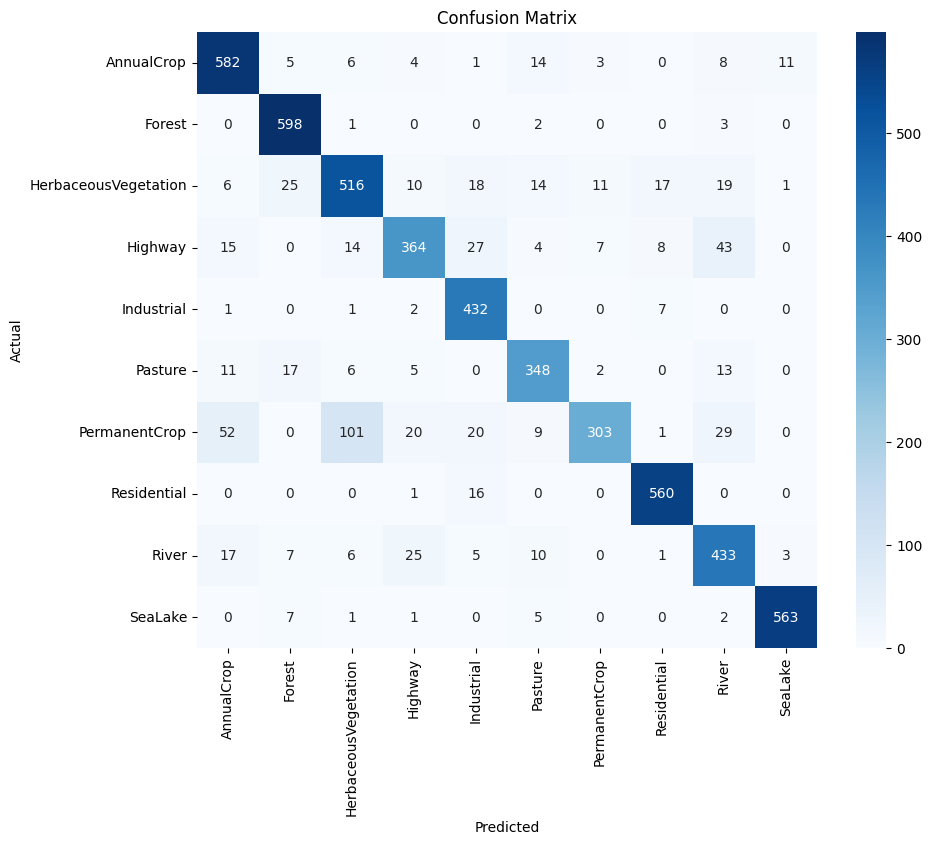

In [52]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<a id="test-images"></a>

#### Test accuracy is 87%. Looking at the confusion matrix we can see that most images are correctly classified. The permanent crop is misclassified which makes sense as it reads it as an annual crop, HerbaceousVegetation.
#### Highway is misclassified as a river which makes sense as highways might look like rivers in satellite images or some highways might be near rivers

### 6. Test Images with Predictions

In [53]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.show()

In [54]:
# Get a batch of test data
inputs, classes = next(iter(test_loader))
inputs, classes = inputs.to(device), classes.to(device)
# Make predictions
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

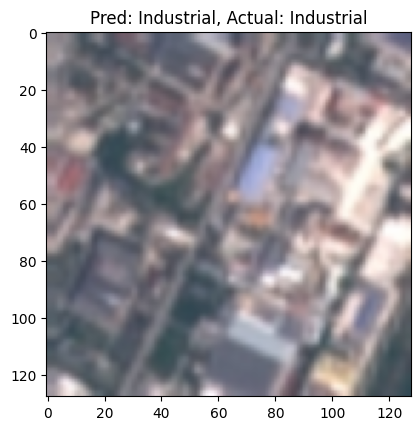

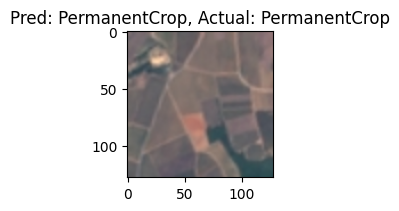

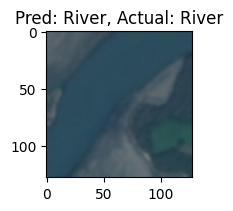

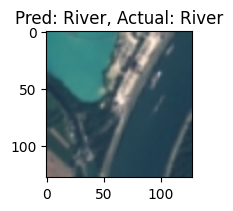

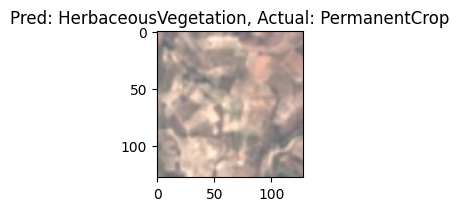

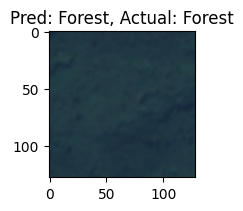

In [55]:
# Plot the images and predictions
plt.figure(figsize=(16, 12))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    imshow(inputs.cpu().data[i], title=f'Pred: {class_names[preds[i]]}, Actual: {class_names[classes[i]]}')

#### The model is able to predict most of the images accurately as seen above in the pictures